In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [4]:
# read data
train_path = '../rsna-2024-lumbar-spine-degenerative-classification-inputs/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [5]:
test_desc.head(5)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [6]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [7]:
train_desc.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [8]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, image) for image in images])
    return image_paths    
    
# Generate image paths for train and test data
train_impage_paths = generate_image_paths(train_desc, f'{train_path}train_images')
test_impage_paths = generate_image_paths(test_desc, f'{train_path}test_images')

In [9]:
len(train_desc)

6294

In [10]:
len(train_impage_paths)

147218

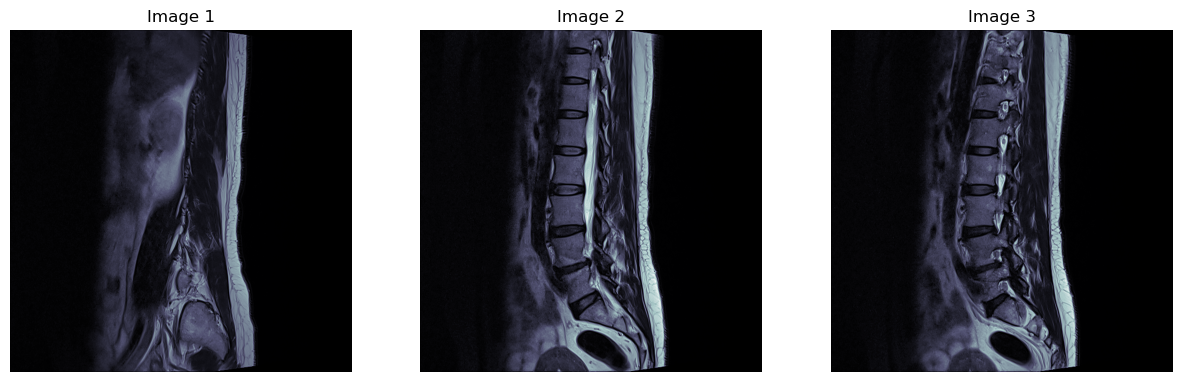

In [11]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f'Image {i+1}')
        plt.axis('off')
    plt.show()
    
# Display first 3 images from train data
display_dicom_images(train_impage_paths)    

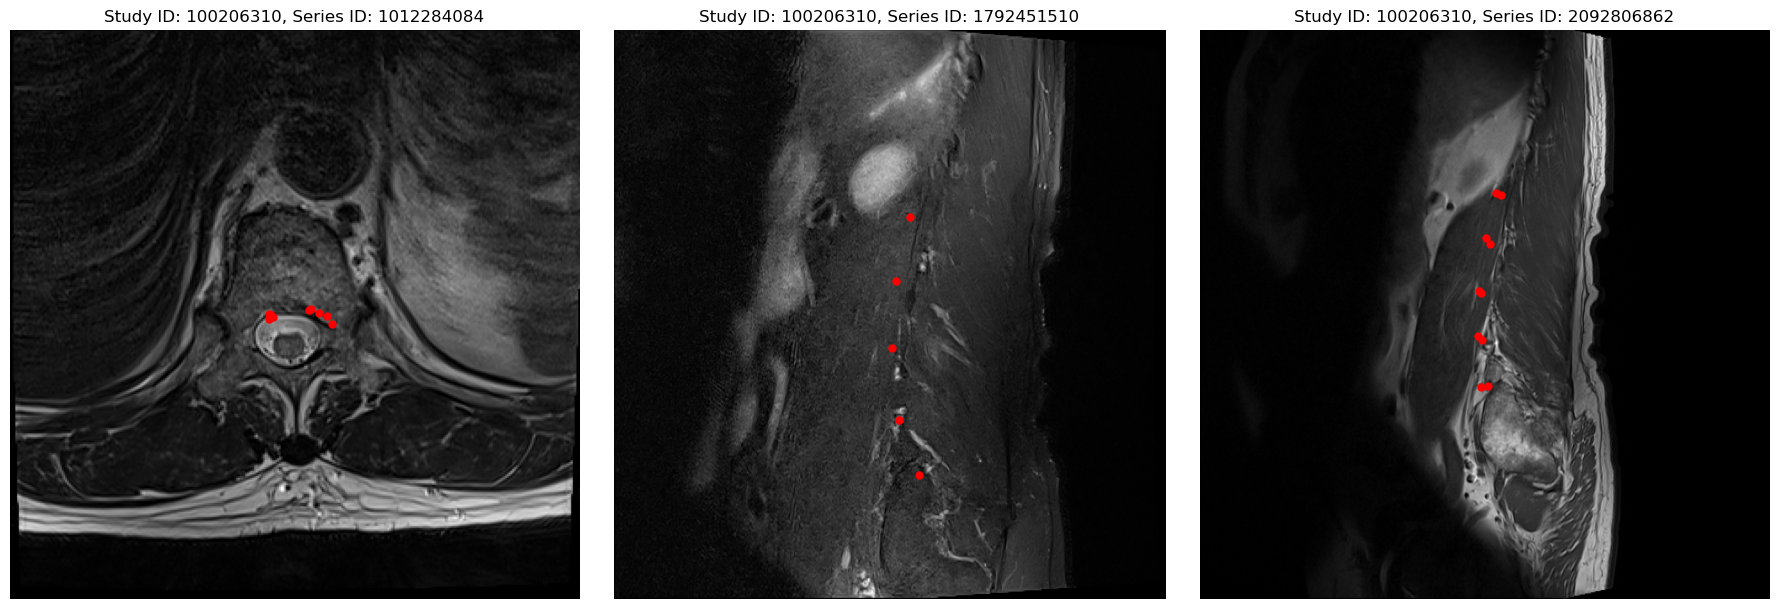

In [12]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):
        study_id = int(path.split('/')[-3])
        series_id = int(path.split('/')[-2])
        
        # Filter label coordinated for the current study and series
        filtered_labels = label_df[(label_df["study_id"] == study_id) & (label_df["series_id"] == series_id)]
        assert len(filtered_labels) > 0, f"No label coordinates found for Study ID: {study_id}, Series ID: {series_id}"
        
        # Read DICOM image
        assert os.path.isfile(path), f"File not found: {path}"
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot label coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
            
    plt.tight_layout()
    plt.show()
        
# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
study_folder = f'{train_path}train_images/{study_id}'    

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])
        
display_dicom_with_coordinates(image_paths, label)        

In [13]:
def reshape_row(row):
    data = {
        'study_id': [],
        'condition': [],
        'level': [],
        'severity': [],
    }
    
    for column, value in row.items():
        if column not in ['study_id', 'condition', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join(word.capitalize() for word in parts[:-2])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows on the reshaped dataframe
new_train_df.head(10)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild


In [14]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [15]:
# Merge the dataframe on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')

# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['study_id', 'series_id'], how='inner')

In [16]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['study_id', 'series_id'], how='inner')

# Display the first few rows of the final merged dataframe
final_merged_df.head(10)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,12,191.321555,170.120141,Sagittal T1
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,12,187.878354,217.245081,Sagittal T1
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,11,186.504472,251.592129,Sagittal T1
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,11,197.100569,289.457306,Sagittal T1


In [17]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x', 'y'], ascending=True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2


In [18]:
test = final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")
test

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


Now, we can see what the data represents

Series ID 1012284084 contains 60 images, and how each image maps to each level and condition

In [19]:
print(len(test))

10


In [20]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("condition")

# Display_df
filtered_df


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11436,1013589491,Left Subarticular Stenosis,L1/L2,Normal/Mild,598943280,33,273.186813,256.649197,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11437,1013589491,Left Subarticular Stenosis,L2/L3,Normal/Mild,598943280,26,262.799662,242.799662,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2


In [21]:
# Sort final_merged_df by study_id, series_id, and series_description for studt_id == 1013589491
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


We see that,

Saggital T1 images map to Neural Foraminal Narrowing

Axial T2 images map to Subarticular Stenosis

Saggital T2/STIR map to Canal Stenosis

In [22]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' + 
    final_merged_df['condition'] + '_' + 
    final_merged_df['level']
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}train_images/' +
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,../rsna-2024-lumbar-spine-degenerative-classif...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,../rsna-2024-lumbar-spine-degenerative-classif...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,../rsna-2024-lumbar-spine-degenerative-classif...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,../rsna-2024-lumbar-spine-degenerative-classif...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,../rsna-2024-lumbar-spine-degenerative-classif...


In [23]:
final_merged_df[final_merged_df['severity'] == 'Normal/Mild'].value_counts().sum()

37626

In [24]:
final_merged_df[final_merged_df['severity'] == 'Moderate'].value_counts().sum()

7950

In [25]:
# Define the base path for test images
base_path = 'rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}        

# Create a listto store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

""


In [26]:
final_merged_df.head(1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,../rsna-2024-lumbar-spine-degenerative-classif...


In [27]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [28]:
test_data = expanded_test_desc
train_data = final_merged_df

In [29]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a Study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the function to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[
    (train_data['study_id_exists']) &
    (train_data['series_id_exists']) &
    (train_data['image_exists'])
]

In [30]:
train_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True


In [31]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

# Keep in mind this potential improvement to avoid quantizing the image data and loosing precision
# data = (data - np.min(data)) / (np.max(data) - np.min(data))
# data = data.astype(np.float32)

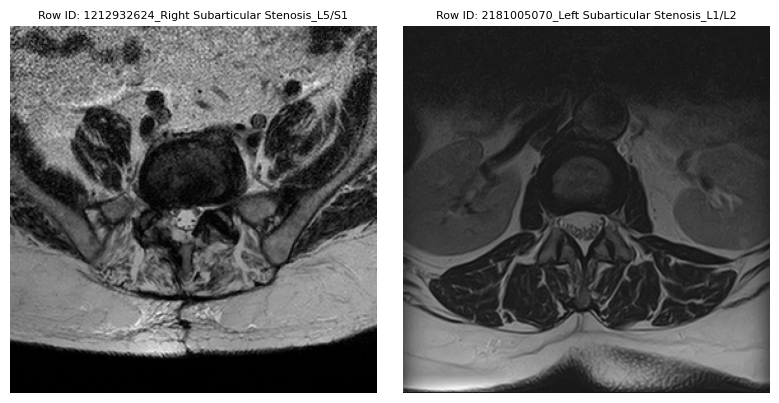

In [32]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')    
fig.tight_layout()
plt.show()

## Loading data

In [33]:
#for one hot encoding
#train_data[['normal_mild', 'severe', 'moderate']] = train_data[['normal_mild', 'severe', 'moderate']].astype(int)  

In [34]:
train_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L1/L2,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L2/L3,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L3/L4,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L4/L5,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_Spinal Canal Stenosis_L5/S1,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_Right Subarticular Stenosis_L1/L2,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_Right Subarticular Stenosis_L2/L3,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_Right Subarticular Stenosis_L3/L4,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_Right Subarticular Stenosis_L4/L5,../rsna-2024-lumbar-spine-degenerative-classif...,True,True,True


In [35]:
train_data = train_data.dropna()

In [36]:
from fastai.vision.all import *
import pandas as pd
from collections import defaultdict

def custom_splitter(items, valid_pct=0.2, seed=42):
    # Group items by study_id
    study_id_to_indices = defaultdict(list)
    for idx, item in enumerate(items):
        study_id = item['study_id']  # Assuming each item is a dict with a 'study_id' key
        study_id_to_indices[study_id].append(idx)
    
    # Get list of study_ids
    study_ids = list(study_id_to_indices.keys())
    
    # Shuffle study_ids
    random.seed(seed)
    random.shuffle(study_ids)
    
    # Calculate number of validation groups
    n_valid = int(len(study_ids) * valid_pct)
    
    # Split into validation and training sets
    valid_study_ids = study_ids[:n_valid]
    train_study_ids = study_ids[n_valid:]
    
    # Get indices for validation and training sets
    valid_indices = [idx for study_id in valid_study_ids for idx in study_id_to_indices[study_id]]
    train_indices = [idx for study_id in train_study_ids for idx in study_id_to_indices[study_id]]
    
    return train_indices, valid_indices

def custom_splitter_wrapper(df):
    return custom_splitter(df.to_dict('records'), valid_pct=0.2, seed=42)

# Debug the get_x function to see how 'row' is being accessed
def get_x(row):
    image_path = row.get('image_path', None)
    return load_dicom(image_path)

# Create a DataBlock for each series description
def create_datablock(
    series_description,
    df,
    label_map,
    item_tfms=[Resize(224)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats)],
    bs=8):
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),  # Image and label block
        get_x=get_x,  # Get image path from dataframe
        get_y=ColReader('severity', pref='', suff='', label_delim=None),  # Map severity to labels
        splitter=custom_splitter_wrapper,  # Train/Validation split
        item_tfms=item_tfms,  # Resize images to 224x224
        batch_tfms=batch_tfms  # Normalize using ImageNet stats
    )
    
    # Apply the DataBlock to create the DataLoaders for the specified series description
    filtered_df = df[df['series_description'] == series_description]
    dls = dblock.dataloaders(filtered_df, bs=bs)
    
    return dls

# Dictionary mapping labels to indices
label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}

# Create DataLoaders for each series description
dataloaders = {}
dataloaders['Sagittal T1'] = create_datablock('Sagittal T1', train_data, label_map)
dataloaders['Axial T2'] = create_datablock('Axial T2', train_data, label_map)
dataloaders['Sagittal T2/STIR'] = create_datablock('Sagittal T2/STIR', train_data, label_map)

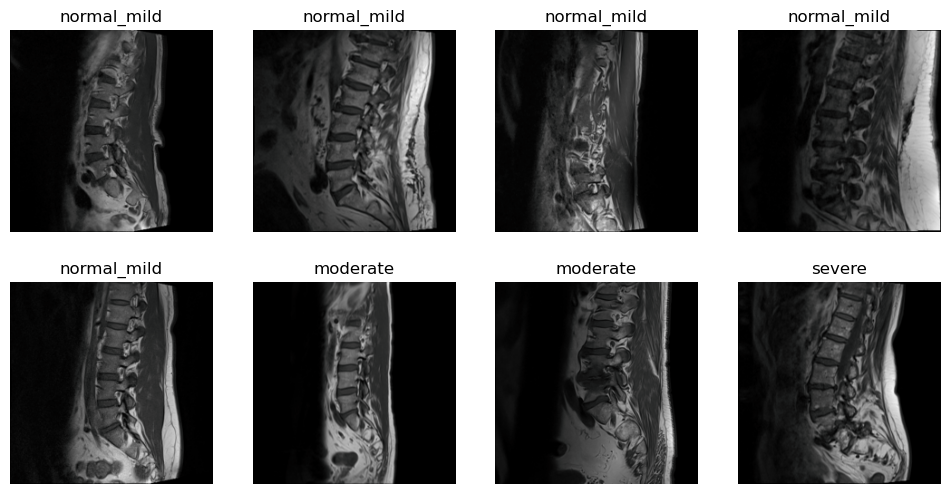

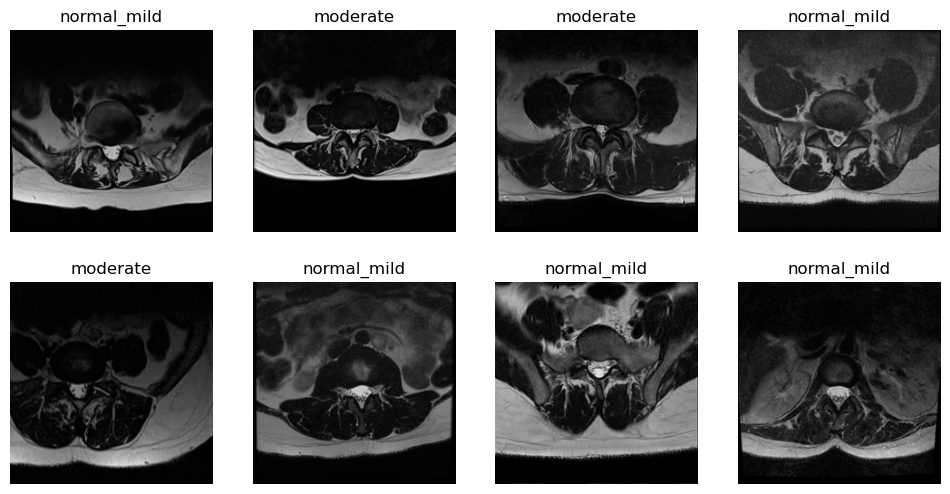

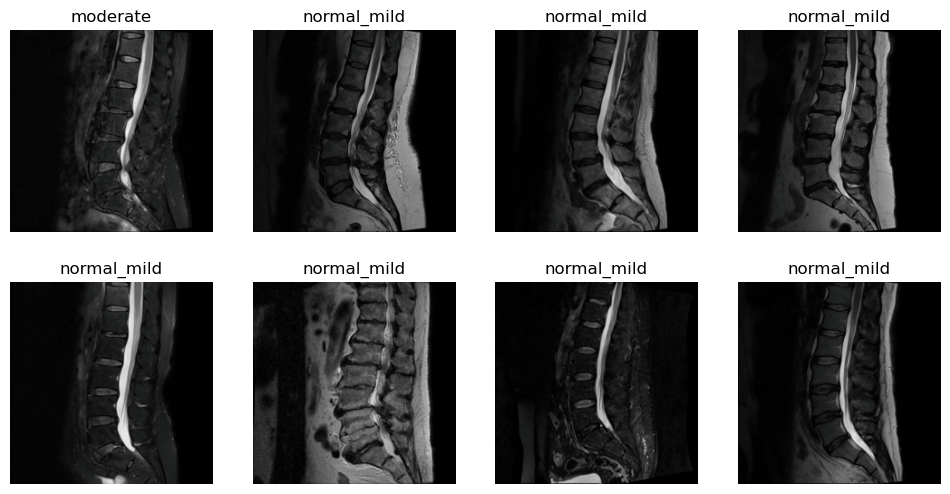

In [37]:
import matplotlib.pyplot as plt

dataloaders['Sagittal T1'].show_batch()
dataloaders['Axial T2'].show_batch()
dataloaders['Sagittal T2/STIR'].show_batch()       

# FastAI Model

In [38]:
from fastai.vision.all import *
import timm

# Function to create a custom ResNet18 model with a different number of classes
def create_custom_model(model_name: str, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    
    # Modify the final fully connected layer to match the number of classes
    if 'conv' in model_name.lower():  # Adjust for ConvNext models
        # ConvNeXt models typically use an Adaptive Pooling layer before the final head
        model.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Downscale to 1x1 feature map
            nn.Flatten(),  # Flatten the feature map
            nn.Linear(model.num_features, num_classes)  # Replace the head with custom number of classes
        )
    else:  # For other models with a fully connected layer named 'fc'
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
   
    return model

# Create custom models for each type of scan
model_name = 'convnext_tiny'
# model_name = 'convnext_large'
sagittal_t1_model = create_custom_model(model_name, num_classes=3)
axial_t2_model = create_custom_model(model_name, num_classes=3)
sagittal_t2stir_model = create_custom_model(model_name, num_classes=3)

# Use the same loss function for all models
criterion = nn.CrossEntropyLoss()

# Using FastAI's Learner for training each model
patience = 3
sagittal_t1_learner = Learner(
    dataloaders['Sagittal T1'], 
    sagittal_t1_model, 
    loss_func=criterion, 
    opt_func=Adam,
    metrics=[accuracy],
    cbs=[EarlyStoppingCallback(monitor='accuracy', patience=patience)]
)
axial_t2_learner = Learner(
    dataloaders['Axial T2'], 
    axial_t2_model, 
    loss_func=criterion, 
    opt_func=Adam,
    metrics=[accuracy],
    cbs=[EarlyStoppingCallback(monitor='accuracy', patience=patience)]
)
sagittal_t2stir_learner = Learner(
    dataloaders['Sagittal T2/STIR'], 
    sagittal_t2stir_model,
    loss_func=criterion,
    opt_func=Adam,
    metrics=[accuracy],
    cbs=[EarlyStoppingCallback(monitor='accuracy', patience=patience)]
)

# Store learners in a dictionary for easier access
learners = {
    'Sagittal T1': sagittal_t1_learner,
    'Axial T2': axial_t2_learner,
    'Sagittal T2/STIR': sagittal_t2stir_learner
}

In [39]:
# Count of trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 27820899


In [40]:
# Print the summary of the FastAI Learner object
sagittal_t1_learner.summary()

ConvNeXt (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 96 x 56 x 56    
Conv2d                                    4704       True      
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       True      
LayerNorm                                 192        True      
____________________________________________________________________________
                     8 x 56 x 56 x 384   
Linear                                    37248      True      
GELU                                                           
Dropout                                                        
Identity                                                       
____________________________________________________________________________
                     8 x 56 x 56 x 96    
Linear                                

In [41]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

Using device: cuda


In [43]:
# Training all models
print(type(learners))
for desc, learner in learners.items():
    print(f"Training model for {desc}")
    learner.fit_one_cycle(15, lr_max=1e-3)    

<class 'dict'>
Training model for Sagittal T1


epoch,train_loss,valid_loss,accuracy,time
0,0.652414,0.647382,0.774112,02:02
1,0.650874,0.642754,0.774112,02:00
2,0.657762,0.648361,0.774112,02:00
3,0.770318,0.785317,0.774112,01:59


No improvement since epoch 0: early stopping
Training model for Axial T2


epoch,train_loss,valid_loss,accuracy,time
0,0.547569,0.564847,0.773118,01:56
1,0.592387,0.542059,0.772597,01:56
2,0.539680,0.585039,0.729878,01:53
3,0.527550,0.543474,0.749414,01:52


No improvement since epoch 0: early stopping
Training model for Sagittal T2/STIR


epoch,train_loss,valid_loss,accuracy,time
0,0.424297,0.412596,0.872308,00:58
1,0.456361,0.477156,0.872308,00:58
2,0.435068,0.490928,0.872308,00:58
3,0.506049,0.483710,0.872308,00:58


No improvement since epoch 0: early stopping


# Hyper-parameter tuning


In [44]:
import optuna
from fastai.vision.all import *
import timm
from fastai.metrics import accuracy

def objective(trial):
    # Define hyperparameters to search
    resize_method = trial.suggest_categorical('resize_method', ['Resize', 'RandomResizedCrop', 'ResizeSquish', 'ResizeCrop'])
    batch_transforms = trial.suggest_categorical('batch_transforms', [True, False])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    epochs = trial.suggest_int('epochs', 5, 10)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam'])
    
    # Define transformations based on suggested hyperparameters
    if resize_method == 'Resize':
        item_tfms = [Resize(224)]
    elif resize_method == 'RandomResizedCrop':
        item_tfms = [RandomResizedCrop(224, min_scale=0.9)]
    elif resize_method == 'ResizeSquish':
        item_tfms = [Resize(224, method='squish')]
    else:
        item_tfms = [Resize(224, method='crop')]
    
    batch_tfms = [
        *aug_transforms(  # Apply augmentations cautiously
            size=256,
            flip_vert=False,  # Avoid flipping vertically, important for medical data
            max_rotate=10,    # Limit rotations to ±10 degrees
            max_zoom=1.1,     # Slight zooming
            max_lighting=0.2, # Light contrast/brightness adjustment
            p_affine=0.5,     # Probability of affine transform
            p_lighting=0.3    # Probability of lighting transform
        ),
        Normalize.from_stats(*imagenet_stats)  # Normalize based on ImageNet mean/std
    ] if batch_transforms else [Normalize.from_stats(*imagenet_stats)]

    # Create DataLoaders
    dls = create_datablock(
        'Sagittal T1',
        train_data,
        label_map,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=batch_size)
    
    the_model = timm.create_model('convnext_tiny', pretrained=True, num_classes=dls.c)
    # Define the model with dropout
    def create_model():
        model = the_model
        num_ftrs = model.head.fc.in_features
        model.head.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_ftrs, dls.c)
        )
        return model
    
    # Create the learner
    learn = Learner(
        dls, 
        create_model(), 
        metrics=accuracy,
        wd=weight_decay,
        # cbs=[EarlyStoppingCallback(monitor='accuracy', patience=patience)]
        ).to_bf16()
    
    # learn.lr_find(suggest_funcs=(slide, valley))
    
    # Choose optimizer
    if optimizer_name == 'Adam':
        learn.opt_func = Adam
    elif optimizer_name == 'SGD':
        learn.opt_func = SGD
    elif optimizer_name == 'RMSprop':
        learn.opt_func = RMSProp
    
    # Train the model
    learn.fit(epochs, lr)
    
    # Initialize accuracy
    accuracy_result = 0.0
 
    # Evaluate the model
    try:
        # Evaluate the model
        validation_results = learn.validate()
        if validation_results and len(validation_results) > 1:
            accuracy_result = validation_results[1]
    except Exception as e:
        print(f"Validation failed: {e}")
        accuracy_result = 0.0  # Default value if validation fails
 
    return accuracy_result

# Create a study and optimize the objective function
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    direction='maximize',
    study_name='Sagittal T1 - convnext_tiny - custom data splitter - 2')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(study.best_params)

[I 2024-09-13 18:33:54,283] A new study created in RDB with name: Sagittal T1 - convnext_tiny - custom data splitter - 2
/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.539144,0.561849,0.774112,00:51
1,0.523440,0.547551,0.783503,00:50
2,0.515537,0.537254,0.785025,00:49
3,0.499339,0.546750,0.773350,00:50
